# Model-Based Curation Tutorial: Applying Pre-trained Models on Sorting Analyzer

This tutorial demonstrates how to apply pre-trained machine learning models for spike sorting curation using "sorting analyzer" object from Spikeinterface. This workflow is ideal you finished spike sorting your raw data.

In [ ]:
! pip install spikeinterface[full]

In [23]:
import spikeinterface as si
import spikeinterface.curation as sc
import spikeinterface.widgets as sw

print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.102.3


UnitRefine includes dedicated pre-trained models for different curation tasks, such as removing noisy units and identifying SUA

Models can be loaded directly from the Hugging Face Hub (https://huggingface.co/AnoushkaJain3/models) or from local files. The load_model function automatically handles both and returns the model together with its metadata.

Below is an example using a small demo noise-classifier model from Hugging Face, trained to identify units dominated by noise or artifacts.

In [20]:
model, model_info = sc.load_model(
    repo_id = "SpikeInterface/UnitRefine_noise_neural_classifier_lightweight",
    trusted = ['numpy.dtype']
)

c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when

In [7]:
print("Model Structure:")
print(f"Pipeline steps: {[step[0] for step in model.steps]}")
print(f"Final estimator: {model.steps[-1][1].__class__.__name__}")

Model Structure:
Pipeline steps: ['imputer', 'scaler', 'classifier']
Final estimator: RandomForestClassifier


### Understanding Feature Requirements

Each model requires certain quality metrics to make predictions. Let’s check which metrics this model needs to run predictions on new data. 

In [13]:
required_features = model.feature_names_in_
print("Required Quality Metrics: ", required_features)

print(f"\nTotal features required: {len(required_features)}")
        
print(f"\nLabel conversion: {model_info.get('label_conversion', 'Not specified')}")

Required Quality Metrics:  ['firing_rate' 'presence_ratio' 'snr' 'isi_violations_ratio'
 'isi_violations_count' 'rp_contamination' 'rp_violations'
 'sliding_rp_violation' 'sync_spike_2' 'sync_spike_4' 'sync_spike_8'
 'firing_range' 'sd_ratio' 'peak_to_valley' 'peak_trough_ratio'
 'half_width' 'repolarization_slope' 'recovery_slope' 'num_positive_peaks'
 'num_negative_peaks' 'velocity_above' 'velocity_below' 'exp_decay'
 'spread']

Total features required: 24

Label conversion: {'0': 'neural', '1': 'noise'}


# Create Sorting Analyzer

To use this model, we need to create a `SortingAnalyzer` object, this involves:
1. **Recording object**: loading raw electrophysiology data
2. **Spike Sorting object**: Running a spike sorter and loading the output 


For this tutorial, we'll generate synthetic data that mimics real tetrode recordings.

**Key Resources:**
- [SortingAnalyzer Tutorial](https://spikeinterface.readthedocs.io/en/latest/tutorials/core/plot_4_sorting_analyzer.html#sphx-glr-tutorials-core-plot-4-sorting-analyzer-py)


In [14]:
recording, sorting = si.generate_ground_truth_recording(
    num_channels=4,        # Tetrode configuration
    seed=4,              
    num_units=10,        
    sampling_frequency=30000, 
    durations=[60],      
)


# Create SortingAnalyzer
print("\nCreating SortingAnalyzer and computing extensions...")
sorting_analyzer = si.create_sorting_analyzer(
    sorting=sorting, 
    recording=recording,
    sparse=False  
)

# Compute all extensions required by the model
extensions_to_compute = ['noise_levels', 'random_spikes',
                        'waveforms','templates',
                        'spike_locations','spike_amplitudes',
                        'correlograms', 'principal_components',
                        'quality_metrics', 'template_metrics']

sorting_analyzer.compute(extensions_to_compute)



Creating SortingAnalyzer and computing extensions...


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\spikeinterface\core\generate.py:2258: UserWarning: generate_unit_locations(): no solution for minimum_distance=20 and max_iteration=100
  warnings.warn(f"generate_unit_locations(): no solution for {minimum_distance=} and {max_iteration=}")


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/60 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/60 [00:00<?, ?it/s]

c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: The recording is too short given the specified 'interval_s' and 'min_num_bins'. Drift metrics will be set to NaN
  warnings.warn(


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# compute metrics 
quality_metrics = list(sorting_analyzer.get_extension('quality_metrics').get_data().keys())
template_metrics = list(sorting_analyzer.get_extension('template_metrics').get_data().keys())
all_computed_metrics = quality_metrics + template_metrics

print(len(all_computed_metrics), "metrics computed.")


34 metrics computed.


Applying the Model for Automated Curation

Now we can use our trained model to automatically classify unit quality. The `auto_label_units` function handles feature extraction, preprocessing, and prediction, returning both class labels and confidence scores for each unit.

In [21]:
# Apply model to classify unit quality automatically
print("Applying pre-trained model to classify units...")

labels = sc.auto_label_units(
    sorting_analyzer=sorting_analyzer,
    repo_id="SpikeInterface/toy_tetrode_model",
    trusted=['numpy.dtype']
)


# Display prediction summary
label_counts = labels.iloc[:, 0].value_counts()
print(f"\nPrediction Summary:")
for label, count in label_counts.items():
    percentage = (count / len(labels)) * 100
    print(f"  {label}: {count} units ({percentage:.1f}%)")
        

labels

Applying pre-trained model to classify units...

Prediction Summary:
  good: 9 units (90.0%)
  bad: 1 units (10.0%)


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when

,prediction,probability
0,good,0.747560
1,good,0.903640
2,good,0.904640
3,good,0.787560
4,good,0.835560
5,good,0.613703
6,good,0.912640
7,bad,0.540440
8,good,0.867560
9,good,0.923640


### Visualizing Classification Results

Let's examine the waveform templates of units with different quality classifications to understand what the model is detecting. We'll compare units with high confidence scores for both 'good' and 'bad' classifications.

Best 'good' unit: 9 (confidence: 92.4%)
Best 'bad' unit: 7 (confidence: 54.0%)

Comparing templates for units ['9', '7']


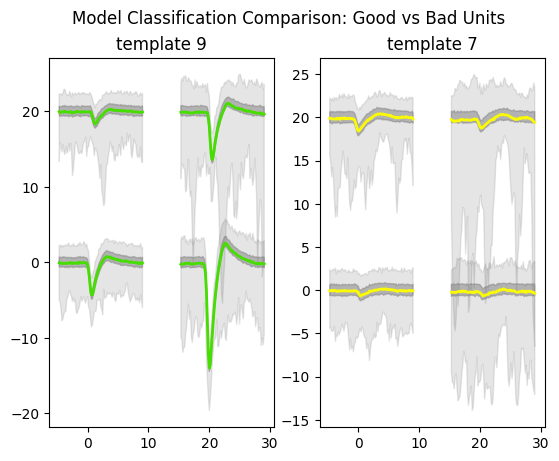

In [25]:
import matplotlib.pyplot as plt

# Identify representative units for visualization
good_units = labels[labels.iloc[:, 0] == 'good']
bad_units = labels[labels.iloc[:, 0] == 'bad']

# Find highest confidence examples of each class
if len(good_units) > 0:
    best_good_unit = good_units.iloc[:, 1].idxmax()
    good_confidence = good_units.loc[best_good_unit, good_units.columns[1]]
    print(f"Best 'good' unit: {best_good_unit} (confidence: {good_confidence:.1%})")

if len(bad_units) > 0:
    best_bad_unit = bad_units.iloc[:, 1].idxmax()
    bad_confidence = bad_units.loc[best_bad_unit, bad_units.columns[1]]
    print(f"Best 'bad' unit: {best_bad_unit} (confidence: {bad_confidence:.1%})")

# Plot template comparison
units_to_plot = []
if len(good_units) > 0:
    units_to_plot.append(best_good_unit)
if len(bad_units) > 0:
    units_to_plot.append(best_bad_unit)

if len(units_to_plot) >= 2:
    print(f"\nComparing templates for units {units_to_plot}")
    sw.plot_unit_templates(sorting_analyzer, unit_ids=units_to_plot)
    plt.suptitle("Model Classification Comparison: Good vs Bad Units")
    plt.show()
else:
    print("Only one class detected - plotting all available units")
    sw.plot_unit_templates(sorting_analyzer, unit_ids=sorting_analyzer.unit_ids[:4])
    plt.show()

### Comparing with Human Curation

To evaluate model performance objectively, we'll compare predictions against simulated human labels and analyze agreement patterns. This helps determine when to trust automated decisions versus requiring manual review.

Human vs Model Comparison Setup:
Human labels (conservative curator): ['good', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'good']
Model predictions: ['good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good']

Model Performance:
Balanced Accuracy: 75.0%


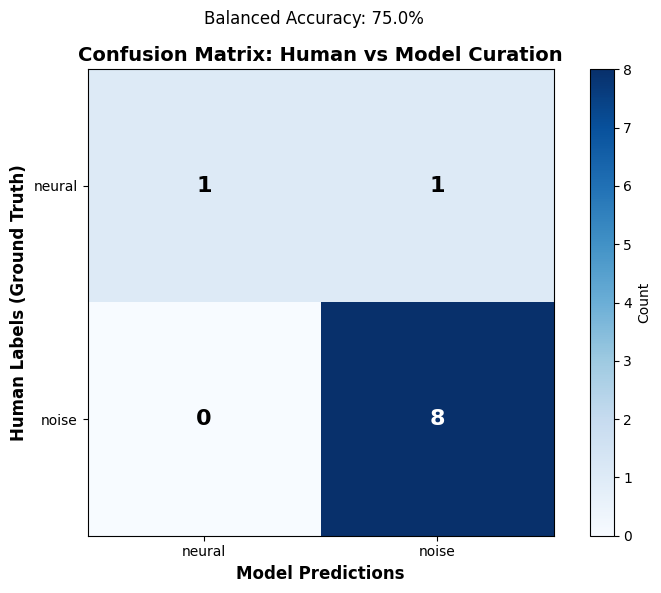


Detailed Performance Metrics:
Precision (good units): 88.9%
Recall (good units): 100.0%
False positive rate: 1/10 units (10.0%)


In [29]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score, confusion_matrix


human_labels = ['good', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'good']

print("Human vs Model Comparison Setup:")
print("Human labels (conservative curator):", human_labels)

# Extract model predictions for analysis
model_predictions = [labels.iloc[i, 0] for i in range(len(labels))]
prediction_confidences = [labels.iloc[i, 1] for i in range(len(labels))]

print("Model predictions:", model_predictions)

# Create confusion matrix
conf_matrix = confusion_matrix(human_labels, model_predictions)
balanced_accuracy = balanced_accuracy_score(human_labels, model_predictions)

print(f"\nModel Performance:")
print(f"Balanced Accuracy: {balanced_accuracy:.1%}")

# Visualize confusion matrix with professional styling
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')

# Add value annotations
for (i, j), value in np.ndenumerate(conf_matrix):
    plt.annotate(str(value), xy=(j, i), ha='center', va='center', 
                color="white" if value > conf_matrix.max()/2 else "black", 
                fontsize=16, fontweight='bold')

# Formatting
label_conversion = model_info['label_conversion']
tick_labels = list(label_conversion.values())
plt.xlabel('Model Predictions', fontsize=12, fontweight='bold')
plt.ylabel('Human Labels (Ground Truth)', fontsize=12, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=tick_labels)
plt.yticks(ticks=[0, 1], labels=tick_labels)
plt.title('Confusion Matrix: Human vs Model Curation', fontsize=14, fontweight='bold')
plt.suptitle(f'Balanced Accuracy: {balanced_accuracy:.1%}', fontsize=12)

# Add colorbar
plt.colorbar(label='Count')
plt.tight_layout()
plt.show()

# Calculate detailed metrics
true_positives = conf_matrix[1, 1]  # Good correctly identified as good
false_positives = conf_matrix[0, 1]  # Bad incorrectly identified as good  
false_negatives = conf_matrix[1, 0]  # Good incorrectly identified as bad
true_negatives = conf_matrix[0, 0]  # Bad correctly identified as bad

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

print(f"\nDetailed Performance Metrics:")
print(f"Precision (good units): {precision:.1%}")
print(f"Recall (good units): {recall:.1%}")
print(f"False positive rate: {false_positives}/{len(human_labels)} units ({false_positives/len(human_labels):.1%})")

## Bonus: Confidence-Based Workflow Optimization

### Understanding Prediction Confidence

Model confidence scores provide crucial information for optimizing curation workflows. High-confidence predictions can often be trusted for automated processing, while low-confidence cases should be flagged for manual review.

This analysis helps determine:
- **Confidence thresholds** for automated acceptance
- **Cases requiring manual review** based on uncertainty
- **Model reliability patterns** across different unit types

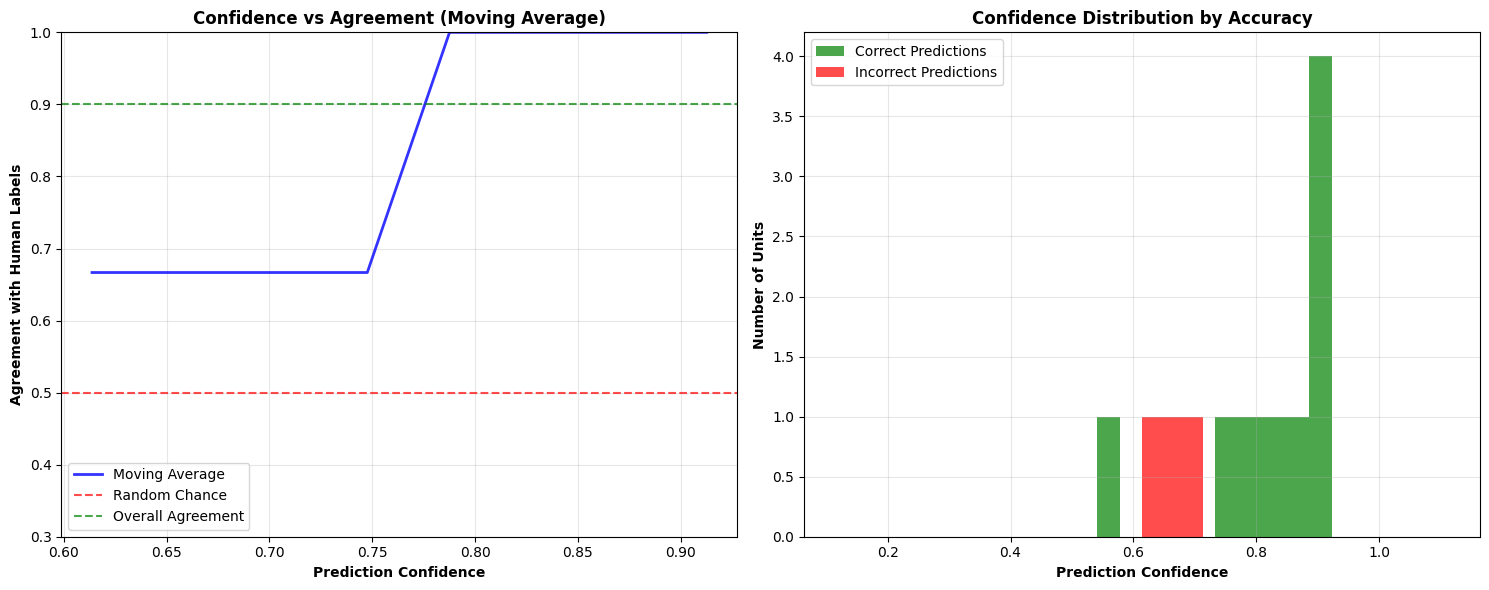


Workflow Recommendations:
High confidence (>80%): 6 units - suitable for automation
Low confidence (<60%): 1 units - require manual review


In [32]:
# Analyze relationship between prediction confidence and accuracy
import pandas as pd

def calculate_confidence_analysis(label_df, confidence_col='confidence', window_size=3):
    """Calculate moving average of prediction accuracy by confidence level."""
    
    # Create confidence deciles for grouping
    label_df[f'{confidence_col}_decile'] = pd.cut(
        label_df[confidence_col], 
        bins=10, 
        labels=False, 
        duplicates='drop'
    )
    
    # Calculate agreement by decile
    decile_agreement = label_df.groupby(f'{confidence_col}_decile')['agreement'].mean()
    
    # Sort by confidence for moving average
    label_df_sorted = label_df.sort_values(by=confidence_col)
    moving_avg_agreement = label_df_sorted['agreement'].rolling(
        window=window_size, 
        center=True
    ).mean()
    
    return label_df_sorted[confidence_col], moving_avg_agreement, decile_agreement

# Extract confidence scores and create analysis dataframe
confidences = sorting_analyzer.sorting.get_property('classifier_probability')

analysis_df = pd.DataFrame({
    'human_label': human_labels,
    'model_label': model_predictions,
    'confidence': confidences
}, index=sorting_analyzer.unit_ids)

# Calculate agreement between human and model labels
analysis_df['agreement'] = (analysis_df['human_label'] == analysis_df['model_label'])

# Perform confidence analysis
conf_sorted, moving_avg, decile_stats = calculate_confidence_analysis(analysis_df, window_size=3)

# Create comprehensive confidence plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Moving average plot
ax1.plot(conf_sorted, moving_avg, 'b-', linewidth=2, label='Moving Average', alpha=0.8)
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Chance')
ax1.axhline(y=analysis_df['agreement'].mean(), color='green', linestyle='--', 
           alpha=0.7, label='Overall Agreement')
ax1.set_xlabel('Prediction Confidence', fontweight='bold')
ax1.set_ylabel('Agreement with Human Labels', fontweight='bold')
ax1.set_title('Confidence vs Agreement (Moving Average)', fontweight='bold')
ax1.set_ylim(0.3, 1)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Confidence distribution by agreement
agreement_true = analysis_df[analysis_df['agreement'] == True]['confidence']
agreement_false = analysis_df[analysis_df['agreement'] == False]['confidence']

ax2.hist(agreement_true, bins=10, alpha=0.7, label='Correct Predictions', color='green')
ax2.hist(agreement_false, bins=10, alpha=0.7, label='Incorrect Predictions', color='red')
ax2.set_xlabel('Prediction Confidence', fontweight='bold')
ax2.set_ylabel('Number of Units', fontweight='bold')
ax2.set_title('Confidence Distribution by Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print confidence-based recommendations
high_conf_threshold = 0.8
low_conf_threshold = 0.6

high_conf_units = analysis_df[analysis_df['confidence'] > high_conf_threshold]
low_conf_units = analysis_df[analysis_df['confidence'] < low_conf_threshold]

print(f"\nWorkflow Recommendations:")
print(f"High confidence (>{high_conf_threshold:.0%}): {len(high_conf_units)} units - suitable for automation")
print(f"Low confidence (<{low_conf_threshold:.0%}): {len(low_conf_units)} units - require manual review")
